In [27]:
from data_180218 import load_data
from spot2intensity import Spots
import pandas as pd
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import copy
from utils import ensure_dir
import numpy as np
from correlation_significance import correlated_significance


In [28]:
collections = load_data()

In [29]:
cs_vir1_names = ["slide_21","slide_22","slide_23","slide_24","slide_25"]
cs_vir2_names = ["slide_26","slide_27","slide_28","slide_29","slide_30"]
cs_vir3_names = ["slide_31","slide_32","slide_33","slide_34","slide_35"]
cs_vir4_names = ["slide_36","slide_37","slide_39","slide_40"]
cs_vir5_names = ["slide_41","slide_42","slide_44","slide_45"]

cs_vir1={collections[c]:"HongKong/4801/2014" for c in cs_vir1_names}
cs_vir2={collections[c]:"Brisbaine/59/2007" for c in cs_vir2_names}
cs_vir3={collections[c]:"Cal" for c in cs_vir3_names}
cs_vir4={collections[c]:"Brisbaine/10/2007" for c in cs_vir4_names}
cs_vir5={collections[c]:"X31" for c in cs_vir5_names}

collections_dict = {}
frames = []

for d in [cs_vir1,cs_vir2,cs_vir3,cs_vir4,cs_vir5]:
    for k, v in d.iteritems():
        collections_dict[k] = v
viruses = set(collections_dict.values())
virus_combinations = list(combinations(viruses,2))

In [30]:
frames = []
for c, virus in collections_dict.iteritems():
    spots_c = Spots.load_pickel(c)
    spots_c.select_by_circlequal(0.4)
    spots_c.add_virus(virus)
    spots_c.add_c_name(c.name)
    frames.append(spots_c.df)
spots = pd.concat(frames)




In [31]:
pivot_spots = spots.pivot_table(values="intensities2",index="Name", columns="Collection")
rank_mean = pivot_spots.stack().groupby(pivot_spots.rank(method='first').stack().astype(int)).mean()
normalized_data = pivot_spots.rank(method='min').stack().astype(int).map(rank_mean)
spots = spots.set_index(["Name","Collection"])
spots["intensities2_norm"] = normalized_data
spots.reset_index(inplace=True)

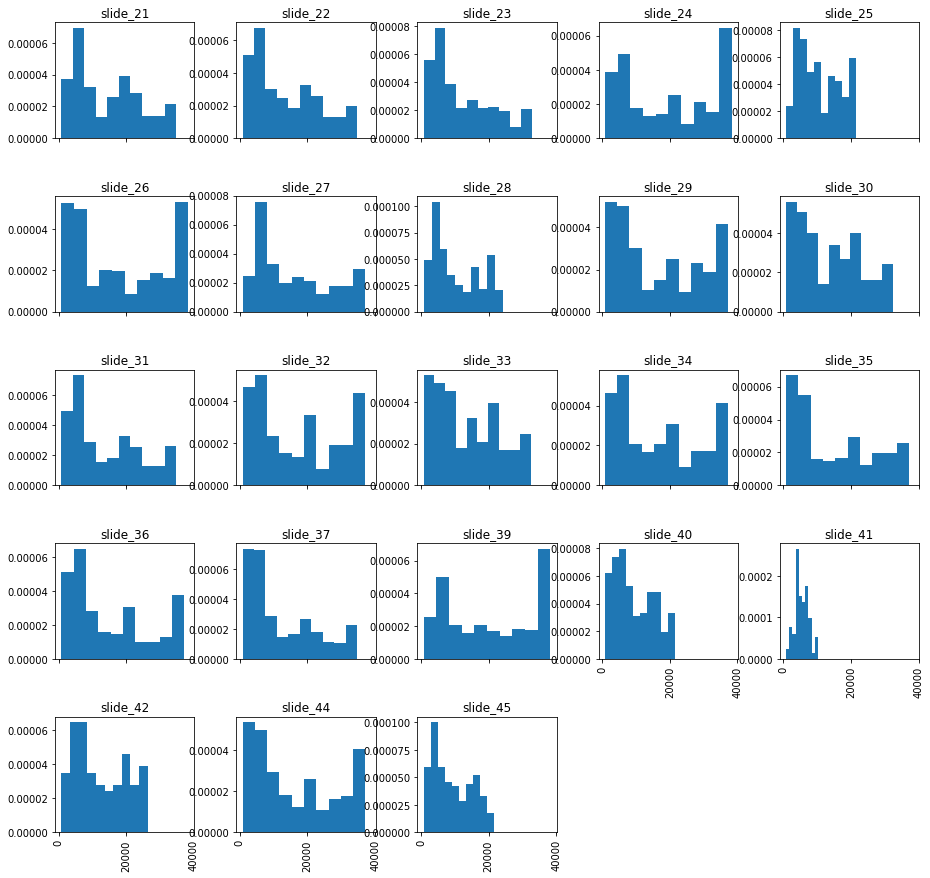

In [32]:
spots.hist(by="Collection", column="intensities2_norm", figsize=(15,15), sharex=True, bins=10, normed=1)
plt.show()

In [33]:
frames = []
for name, data in spots.groupby(["Name","Virus"]):
    x = data.mean()
    x["intensities_mean_std"] = data["intensities"].std(ddof=1)/np.sqrt(len(data))
    x["intensities_var"] = data["intensities2"].var()

    x["intensities2_mean_std"] = data["intensities2"].std(ddof=1)/np.sqrt(len(data))
    x["intensities2_var"] = data["intensities2"].var()
    
    x.name = name
    frames.append(x)
mean_spots = pd.concat(frames, axis=1)
mean_spots = mean_spots.transpose().reset_index()
mean_spots = mean_spots.rename(columns={"level_0":"Peptide Batch","level_1":"Virus"})  



In [34]:
mean_spots_grouped = mean_spots.groupby("Virus")
grouped_combinations = combinations(mean_spots_grouped,2)
frames = []
for (name1,spots1),(name2,spots2) in grouped_combinations:
    peptides = set(spots1["Peptide Batch"].unique()).intersection(set(spots2["Peptide Batch"].unique()))
    
    for peptide in peptides:
        
        spots1_this_pep = spots1.loc[spots1["Peptide Batch"] == peptide]
        spots2_this_pep = spots2.loc[spots2["Peptide Batch"] == peptide]

        v1_i = spots1_this_pep["intensities2"].iloc[0]
        v2_i = spots2_this_pep["intensities2"].iloc[0]
   
        v1_err = spots1_this_pep["intensities2_mean_std"].iloc[0]
        v2_err = spots2_this_pep["intensities2_mean_std"].iloc[0]
        
        v1_var = spots1_this_pep["intensities2_var"].iloc[0]
        v2_var = spots2_this_pep["intensities2_var"].iloc[0]
        
        where_max ,sig_max = correlated_significance(v1_i,v2_i, v1_var, v2_var)
        
        fr = pd.Series([peptide,(name1,name2),sig_max,v1_i,v2_i,v1_err,v2_err,len(spots1_this_pep),len(spots2_this_pep)],index = ["Peptide","Viruses","Significance","v1_i","v2_i","v1_err","v2_err","v1_numb","v2_numb"])
        frames.append(fr)        
        
peptide_c_signif = pd.concat(frames, axis=1).transpose()

/home/janekg89/Envs/flutype_webapp/lib/python2.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


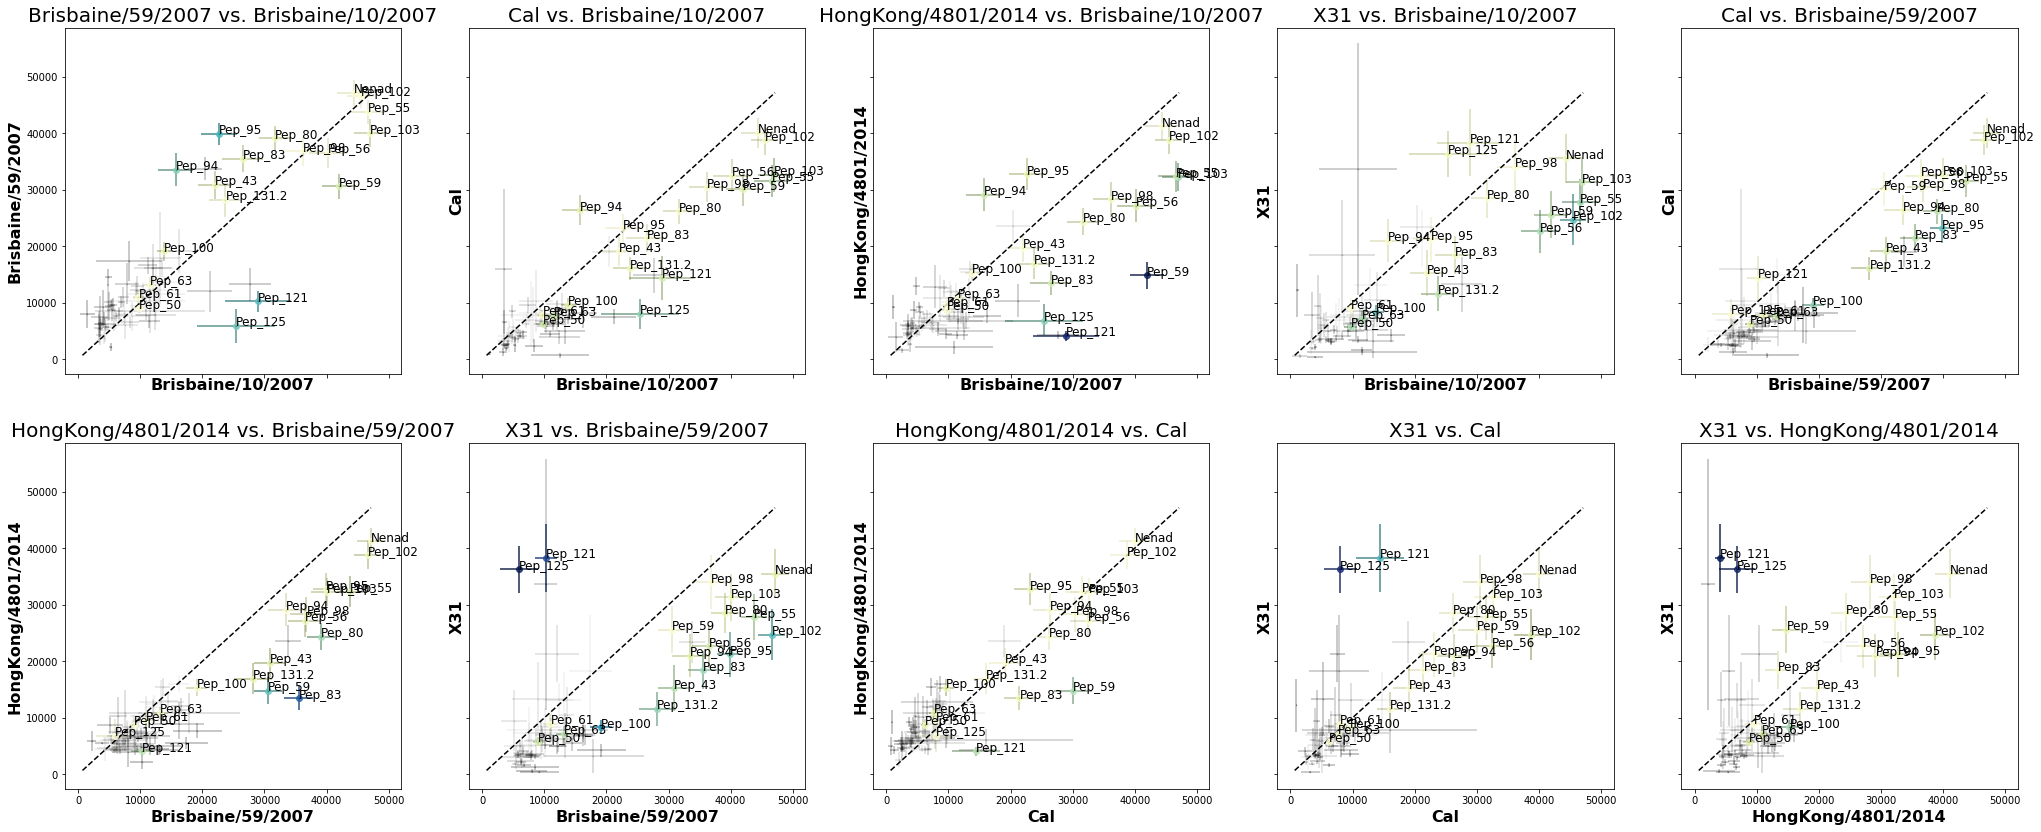

In [35]:
fig, axes = plt.subplots(ncols=5,nrows=2, sharex=True,sharey=True,figsize = (35,14))

ax_it = iter(axes.flatten())
peptide_c_signif.dropna(inplace=True)
cmap = cm.YlGnBu
for name, d in peptide_c_signif.groupby("Viruses"):
    x = y = np.linspace(peptide_c_signif.v1_i.min(),peptide_c_signif.v1_i.max())
    ax = next(ax_it)
    ax.plot(x,y,linestyle="--",marker=" ", c="k", alpha=1)
    ax.set_title("{} vs. {}".format(name[1],name[0]), size = 20)
    ax.set_xlabel(name[0], size = 16, weight = 'bold')
    ax.set_ylabel(name[1], size = 16, weight = 'bold')
    #ax.set_xlim(0,1.1)
    #ax.set_ylim(0,1.1)

    
    #ax.set_xscale("log")
    #ax.set_yscale("log")



    #norm = Normalize(d.Significance.min(),d.Significance.max())
    d.sort_values("Significance",ascending=False, inplace=True)
    boundary = 0.35
    #d_selected = d[d["Significance"] > boundary]
    #d_n = d[d["Significance"] < boundary]
    
    
    #d_n = d
    d_selected = d.loc[d["Peptide"].isin(["Pep_80","Pep_43","Pep_55","Pep_56","Pep_59","Pep_61","Pep_63","Pep_83","Pep_94","Pep_95","Pep_98","Pep_100","Pep_102","Pep_103","Pep_121" ,"Pep_125","Pep_131.2","Nenad","Pep_49","Pep_50"])]
    #d_selected = d.loc[d["Peptide"].isin(["Pep_80"])]


    

    alphas = iter(np.linspace(0.3,0.05,len(d)))
    

    for ii, dp in d_selected.iterrows():
        #if dp.Significance is not np.NaN:
            c = cmap(dp.Significance)
            ax.errorbar(x=dp.v1_i,y=dp.v2_i,xerr=dp.v1_err,yerr=dp.v2_err, c = c, fmt="o",linestyle="",alpha=0.8, capthick=2)
            ax.annotate(dp["Peptide"],(dp.v1_i+0.01,dp.v2_i+0.01), size=12)
    
    for ii, dp in d_n.iterrows():
        c = cmap(dp.Significance)
        ax.errorbar(x=dp.v1_i,y=dp.v2_i,xerr=dp.v1_err,yerr=dp.v2_err, c = "k", fmt="o",linestyle="",alpha=next(alphas), ms = 0.5, capthick=1)
        
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    uri_name1 = name[0].replace("/","-")
    uri_name2 = name[1].replace("/","-")


#plt.savefig(directory+"all_correlations.png", bbox_inches="tight")    
plt.show()    